## APhys Group Meeting (28/10/25)

Analyzing orthogonal components of constriction velocities.

Deconstruct velocities measured at constriction into NS and EW components.  Normalize by the speed to determine the relative contribution of each component.  Compute hourly averages and compare the relative size of the NS component for northward and southward flows.
- We observe that the NS component is greater for northward flows than for southward flows across months and depths.  Northward flows are more directly northward than southward flows are directly south.

Compare the EW direction of northward and southward flows.  For each observation, group by NS flow direction, and then calculate hourly averages of the EW velocity.
- We observe that northward flows tend to flow west, and southward flows tend to flow east.  This aligns with the topography of the constriction, which angles from NW to SE.

In [1]:
# imports
import os
from glob import glob
import dolfyn as dlfn
import xarray as xr
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings; warnings.filterwarnings('ignore')

In [2]:
year_date = [('2024', '20240424'), ('2024', '20240719'), ('2024', '20241017')]
location = 'LZ2'
data_dir = 'Q:/Messdaten/Aphys_hypothesis_data/Zugersee/{year}/Mooring/{location}/{date}/'
md_path = ['Q:/Messdaten/Aphys_hypothesis_data/Zugersee/{year}/Mooring/{location}/{date}/{date}_{location}_meta.tsv',
           'Q:/Messdaten/Aphys_hypothesis_data/Zugersee/{year}/Mooring/{location}/{date}/Notes.txt']

# Lake Zug bathymetry
bathy = xr.open_dataset('../../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

In [3]:
def locate_md_file(md_path, year, date, location):
    for wildcard_path in md_path:
        md_file = wildcard_path.format(year=year, location=location, date=date)
        if os.path.exists(md_file):
            return md_file
        
    raise FileNotFoundError(f'Could not locate metadata file for mooring {location}, date {date}')


# parse metadata file for Switzerland coordinates
def read_md_file(md_file):
    _, ext = os.path.splitext(md_file)

    if ext == '.tsv':
        md = pd.read_csv(md_file, sep='\t')[f'Mooring: {location}']
        lon_mask = md.str.startswith('Longitude').fillna(False)
        lat_mask = md.str.startswith('Latitude').fillna(False)
        xsc = int(md.loc[lon_mask].iloc[0].split()[-1]) + int(2e6)
        ysc = int(md.loc[lat_mask].iloc[0].split()[-1]) + int(1e6)


    elif ext == '.txt':
        with open(md_file, 'r') as f:
            lines = f.read().splitlines()

            for l in lines:
                if 'coord' in l:
                    _, xsc, ysc = l.split()
                    break

        xsc = int(xsc) + int(2e6)
        ysc = int(ysc) + int(1e6)
    
    else:
        raise ValueError('Metadata file should be .tsv or .txt')
    
    return {'xsc': xsc, 'ysc': ysc}


def gather_adcp_attrs(ds, depth=None):
    serial_id = str(ds.attrs['serialnum'])
    freq = ds.attrs['freq']
    bin_size = ds.attrs['cell_size']

    # conditionals correct for 2024 moorings (I THINK)
    if serial_id == '16576':
        orient = 'up'
    elif serial_id == '24399':
        orient = 'down'
    else:
        orient = ds.attrs['orientation']

    # if ADCP measure pressure, use ADCPs depth
    if 'pressure' in ds.data_vars and not depth:
        depth = ds.depth.where(ds.depth != 0, drop=True).mean().item()
    else:
        raise ValueError('ADCP does not measure pressure, use manual depth measurement.')

    return {'serial_id': serial_id, 'freq': freq, 'bin_size': bin_size, 'orient': orient, 'depth': depth}


def omit_downupcast_time(ds):
    dt_min = ds.time.min().values
    dt_max = ds.time.max().values
    dt_start = dt_min + pd.Timedelta(hours=12)
    dt_end = dt_max - pd.Timedelta(hours=6)

    # select timeframe excluding downcast and upcast
    return ds.sel(time=slice(dt_start, dt_end)), dt_start, dt_end


# update range relative to depth
def range_to_depth(ds, attrs):
    if attrs['orient'] == 'down':
        ds['range'] = attrs['depth'] + ds.range.values
    elif attrs['orient'] == 'up':
        ds['range'] = attrs['depth'] - ds.range.values

    return ds


#  interface detection


# minimum correlation
# flag data with at least 1 beam correlation < 64
def qa_min_corr(ds, corr_thresh=64):
    corr1 = ds.corr.sel(beam=1) >= corr_thresh
    corr2 = ds.corr.sel(beam=2) >= corr_thresh
    corr3 = ds.corr.sel(beam=3) >= corr_thresh
    corr4 = ds.corr.sel(beam=4) >= corr_thresh

    return ds.where(corr1 & corr2 & corr3 & corr4)


# minimum good data percentage
# flag data with PG1 + PG4 < 25%
def qa_pg14(ds, pg14_thresh=25):
    pg14 = ds.prcnt_gd.sel(beam=1) + ds.prcnt_gd.sel(beam=4)

    return ds.where(pg14 >= pg14_thresh)


# maximum bad data percentage
# flag data with PG3 > 25%
def qa_pg3(ds, pg3_thresh = 25):
    pg3 = ds.prcnt_gd.sel(beam=3)

    return ds.where(pg3 <= pg3_thresh)


# maximum velocity error
# flag data with velocity error > 0.05 m/s


# maximum tilt
# flag data with pitch or roll angle > 15°


# maxmimum 4-beams correlation difference
# flag data with differences in correlation ratio with standard deviation > 0.01


# minimum vertical echo difference (only required if beam reaches bottom or surface)
# flag data with at least one beam with vertical echo difference between consecutive bins > 30
def qa_echo_amp_diff(ds, ead_thresh=30):
    echo_amp_diff = ds.amp.diff(dim='range')
    ead1 = echo_amp_diff.sel(beam=1) <= ead_thresh
    ead2 = echo_amp_diff.sel(beam=2) <= ead_thresh
    ead3 = echo_amp_diff.sel(beam=3) <= ead_thresh
    ead4 = echo_amp_diff.sel(beam=4) <= ead_thresh

    return ds.where(ead1 & ead2 & ead3 & ead4)
    


In [91]:
def find_constriction_bounds(depth, md, theta, bathy):
    bounds = {}
    # NE boundary
    for i in range(len(bathy.ysc)):
        xsc = int(md['xsc'] + i * np.cos(theta))
        ysc = int(md['ysc'] + i * np.sin(theta))

        if math.isnan(bathy.sel(xsc=xsc, ysc=ysc).depth.item()):
            break

    bounds['xne'] = xsc
    bounds['yne'] = ysc

    # SW boundary
    for i in range(len(bathy.ysc)):
        xsc = int(md['xsc'] - i * np.cos(theta))
        ysc = int(md['ysc'] - i * np.sin(theta))

        if math.isnan(bathy.sel(xsc=xsc, ysc=ysc).depth.item()):
            break

    bounds['xsw'] = xsc
    bounds['ysw'] = ysc

    return bounds

In [31]:
def calculate_NS_component(ds, md):
    # condition on depth between surface and bottom
    ds.where((ds.range > 0) & (ds.range < md['total_depth']), drop=True)

    # east-west velocity
    u = ds.vel.sel(dir='E')

    # north-south velocity
    v = ds.vel.sel(dir='N')

    # normalize by magnitude
    spd = np.sqrt((u**2) + (v**2))
    ns_norm = v / spd
    #ew_norm = u / spd

    ns_norm = ns_norm.rename('vel_norm').rename({'range': 'depth'}).to_dataframe().dropna().reset_index()
    ns_norm['month'] = ns_norm['time'].dt.month
    ns_norm['day'] = ns_norm['time'].dt.date
    ns_norm['hour'] = ns_norm['time'].dt.floor('h')
    ns_norm = ns_norm.sort_values(by=['time', 'depth'], ascending=True)

    """
    ew_norm = ew_norm.rename('vel_norm').rename({'range': 'depth'}).to_dataframe().dropna().reset_index()
    ew_norm['month'] = ew_norm['time'].dt.month
    ew_norm['day'] = ew_norm['time'].dt.date
    ew_norm['hour'] = ew_norm['time'].dt.floor('h')
    ew_norm = ew_norm.sort_values(by=['time', 'depth'], ascending=True)
    """

    return ns_norm #, ew_norm

In [ ]:
data_ns_norm = []
#data_ew_norm = []
for (year, date) in year_date:
    root = data_dir.format(year=year, location=location, date=date)
    md_file = locate_md_file(md_path, year, date, location)
    md = read_md_file(md_file)
    md['total_depth'] = bathy.sel(xsc=md['xsc'], ysc=md['ysc']).depth.item()

    adcps = [os.path.join(root, a) for a in glob('*.000', root_dir=root)]

    for adcp in tqdm(adcps):
        ds = dlfn.read(adcp)
        attrs = gather_adcp_attrs(ds)

        ds, dt_start, dt_end = omit_downupcast_time(ds)
        attrs['dt_start'] = dt_start
        attrs['dt_end'] = dt_end
        ds = range_to_depth(ds, attrs)

        # quality assurance
        ds = qa_min_corr(ds, corr_thresh=64)
        ds = qa_pg14(ds, pg14_thresh=25)
        ds = qa_pg3(ds, pg3_thresh = 25)
        ds = qa_echo_amp_diff(ds, ead_thresh=30)

        ns_norm = calculate_NS_component(ds, md)
        data_ns_norm.append(ns_norm)
        #data_ew_norm.append(ew_norm)

  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240424/2_300000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240424/2_600000.000 ...


  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240719/DPL3_000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240719/DPL4_000.000 ...


  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20241017/3D576000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20241017/6U399000.000 ...


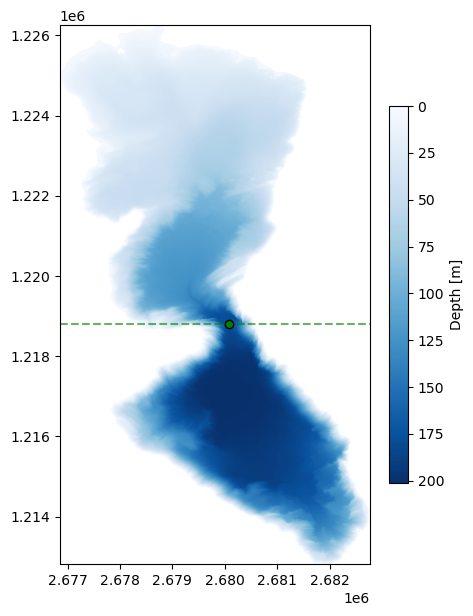

In [97]:
fig, ax = plt.subplots(figsize=(5, 7))
colors = ['purple', 'red', 'green']

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

ax.axhline(md['ysc'], c=colors[i], ls='--', alpha=0.6)
ax.scatter(md['xsc'], md['ysc'], c=colors[i], edgecolor='black')

plt.show()

In [33]:
data_ns_norm = pd.concat(data_ns_norm,  ignore_index=True)
data_ns_norm = data_ns_norm.sort_values(by=['time', 'depth'], ascending=True)

#data_ew_norm = pd.concat(data_ew_norm,  ignore_index=True)
#data_ew_norm = data_ew_norm.sort_values(by=['time', 'depth'], ascending=True)


In [34]:
data_ns_norm_avg = data_ns_norm.groupby(['dir', 'depth', 'month', 'day', 'hour'])['vel_norm'].mean().reset_index()
#data_ew_norm_avg = data_ew_norm.groupby(['dir', 'depth', 'month', 'day', 'hour'])['vel_norm'].mean().reset_index()

In [35]:
#data_ns_norm_avg['abs_vel_norm'] = data_ns_norm_avg['vel_norm'].abs()
data_ns_norm_avg['sq_vel_norm'] = data_ns_norm_avg['vel_norm']**2
data_ns_norm_avg['flow_dir'] = ['N' if x > 0 else 'S' for x in data_ns_norm_avg.vel_norm]

#data_ew_norm_avg['sq_vel_norm'] = data_ew_norm_avg['vel_norm']**2
#data_ew_norm_avg['flow_dir'] = ['E' if x > 0 else 'W' for x in data_ns_norm_avg.vel_norm]

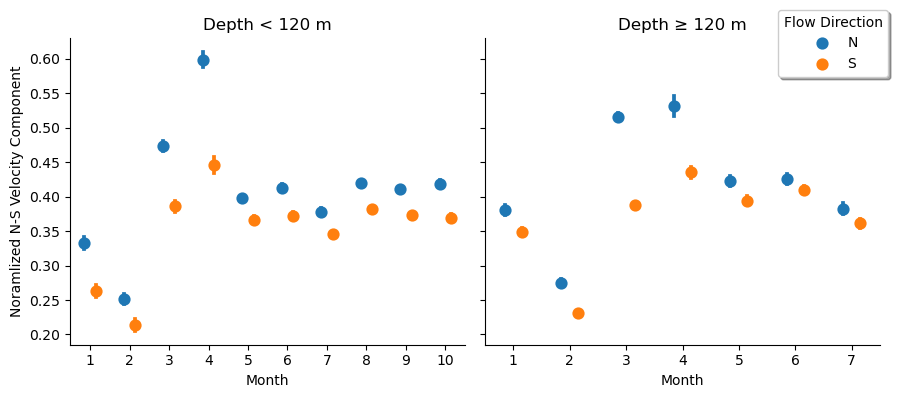

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

depth_thresh = 120
sns.pointplot(data_ns_norm_avg.query("depth < @depth_thresh"), x='month', y='sq_vel_norm', hue='flow_dir', hue_order=['N', 'S'],
              linestyle='none', dodge=0.3, errorbar=('se', 1.96), ax=ax[0], legend=False)

sns.pointplot(data_ns_norm_avg.query("depth >= @depth_thresh"), x='month', y='sq_vel_norm', hue='flow_dir', hue_order=['N', 'S'],
              linestyle='none', dodge=0.3, errorbar=('se', 1.96), ax=ax[1])

ax[0].set_xlabel('Month')
ax[1].set_xlabel('Month')
ax[0].set_ylabel('Noramlized N-S Velocity Component')
ax[0].set_title(f'Depth < {depth_thresh} m')
ax[1].set_title(f'Depth ≥ {depth_thresh} m')

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)

handles, labels = ax[1].get_legend_handles_labels()
ax[1].get_legend().remove()
fig.legend(handles, labels, title='Flow Direction', ncols=1, shadow=True, loc='upper right', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [62]:
def conditional_EW_on_NS(ds, md, attrs):
    # condition on depth between surface and bottom
    ds = ds.where((ds.range > 0) & (ds.range < md['total_depth']), drop=True)

    # east-west velocity
    u = ds.vel.sel(dir='E')

    # north-south velocity
    v = ds.vel.sel(dir='N')

    # condition EW flow on NS flow direction
    n_flow = u.where(v > 0).to_dataframe().dropna().reset_index()
    n_flow['flow_dir'] = 'N'
    s_flow = u.where(v < 0).to_dataframe().dropna().reset_index()
    s_flow['flow_dir'] = 'S'

    ew_conditional =  pd.concat([n_flow, s_flow], ignore_index=True).rename(columns={'range': 'depth'})
    ew_conditional['dt_start'] = attrs['dt_start'].date()
    ew_conditional['month'] = ew_conditional['time'].dt.month
    ew_conditional['day'] = ew_conditional['time'].dt.date
    ew_conditional['hour'] = ew_conditional['time'].dt.floor('h')
    ew_conditional = ew_conditional.sort_values(by=['time', 'depth'], ascending=True)

    return ew_conditional

In [63]:
data_ew_conditional = []
for (year, date) in year_date:
    root = data_dir.format(year=year, location=location, date=date)
    md_file = locate_md_file(md_path, year, date, location)
    md = read_md_file(md_file)
    md['total_depth'] = bathy.sel(xsc=md['xsc'], ysc=md['ysc']).depth.item()

    adcps = [os.path.join(root, a) for a in glob('*.000', root_dir=root)]

    for adcp in tqdm(adcps):
        ds = dlfn.read(adcp)
        attrs = gather_adcp_attrs(ds)

        ds, dt_start, dt_end = omit_downupcast_time(ds)
        attrs['dt_start'] = dt_start
        attrs['dt_end'] = dt_end
        ds = range_to_depth(ds, attrs)

        # quality assurance
        ds = qa_min_corr(ds, corr_thresh=64)
        ds = qa_pg14(ds, pg14_thresh=25)
        ds = qa_pg3(ds, pg3_thresh = 25)
        ds = qa_echo_amp_diff(ds, ead_thresh=30)

        ew_conditional = conditional_EW_on_NS(ds, md, attrs)
        data_ew_conditional.append(ew_conditional)

  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240424/2_300000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240424/2_600000.000 ...


  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240719/DPL3_000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20240719/DPL4_000.000 ...


  0%|          | 0/2 [00:00<?, ?it/s]


Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20241017/3D576000.000 ...

Reading file Q:/Messdaten/Aphys_hypothesis_data/Zugersee/2024/Mooring/LZ2/20241017/6U399000.000 ...


In [64]:
data_ew_conditional = pd.concat(data_ew_conditional,  ignore_index=True)
data_ew_conditional = data_ew_conditional.sort_values(by=['time', 'depth'], ascending=True)

In [80]:
data_ew_conditional_avg = data_ew_conditional.groupby(['flow_dir', 'depth', 'dt_start', 'month', 'day', 'hour'], sort=False)['vel'].mean().reset_index()
data_ew_conditional_avg['depth_bin'] = data_ew_conditional_avg['depth'] // 10
data_ew_conditional_avg = data_ew_conditional_avg.sort_values(by='depth')

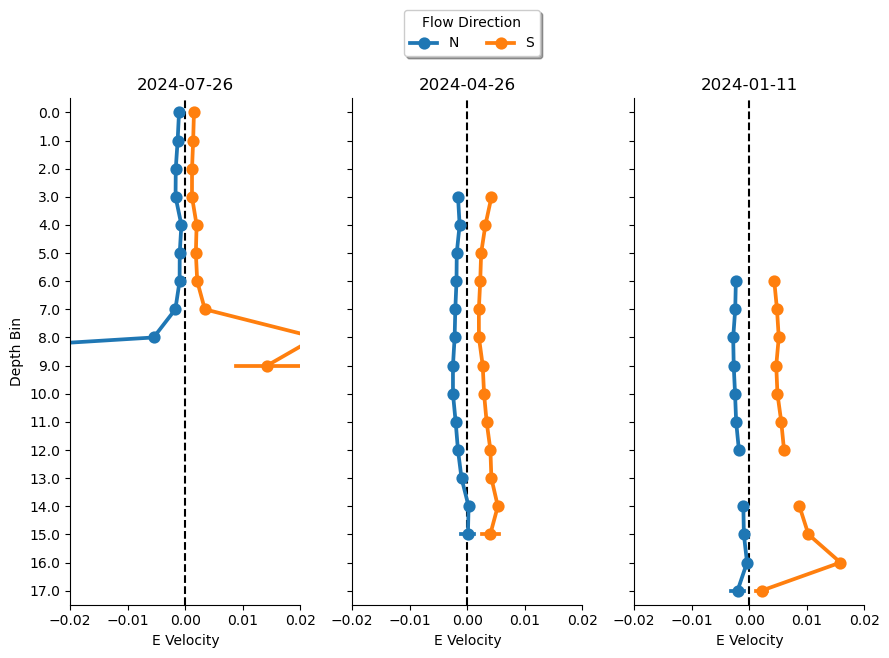

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 6), sharey=True)

dt_order = np.sort(data_ew_conditional_avg['dt_start'].unique())

ax[0].axvline(0, color='black', ls='--')
sns.pointplot(data_ew_conditional_avg.query('dt_start == @dt_order[2]'), x='vel', y='depth_bin', orient='h',
                hue='flow_dir', hue_order=['N', 'S'], errorbar=('se', 1.96), ax=ax[0], legend=False)

ax[1].axvline(0, color='black', ls='--')
sns.pointplot(data_ew_conditional_avg.query('dt_start == @dt_order[1]'), x='vel', y='depth_bin', orient='h',
                hue='flow_dir', hue_order=['N', 'S'], errorbar=('se', 1.96), ax=ax[1], legend=False)

ax[2].axvline(0, color='black', ls='--')
sns.pointplot(data_ew_conditional_avg.query('dt_start == @dt_order[0]'), x='vel', y='depth_bin', orient='h',
                hue='flow_dir', hue_order=['N', 'S'], errorbar=('se', 1.96), ax=ax[2])

ax[0].set_xlabel('E Velocity')
ax[1].set_xlabel('E Velocity')
ax[2].set_xlabel('E Velocity')

ax[0].set_ylabel('Depth Bin')
ax[1].set_ylabel('Depth Bin')
ax[2].set_ylabel('Depth Bin')

ax[0].set_xlim(-0.02, 0.02)
ax[1].set_xlim(-0.02, 0.02)
ax[2].set_xlim(-0.02, 0.02)

ax[0].set_title(dt_order[2])
ax[1].set_title(dt_order[1])
ax[2].set_title(dt_order[0])

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[2].spines[['right', 'top']].set_visible(False)

handles, labels = ax[2].get_legend_handles_labels()
ax[2].get_legend().remove()
fig.legend(handles, labels, title='Flow Direction', ncols=2, shadow=True, loc='upper center', bbox_to_anchor=(0.53, 1.1))

"""
for i, dt_start in enumerate(np.sort(data_ew_conditional_avg['dt_start'].unique())):
    print(dt_start)
    ax[i].axvline(0, color='black', ls='--')
    sns.pointplot(data_ew_conditional_avg.query('dt_start == @dt_start'), x='vel', y='depth_bin', orient='h', hue='flow_dir', hue_order=['N', 'S'], 
                errorbar=('se', 1.96), ax=ax[i])

    ax[i].set_xlabel('East-West Velocity [m/s]')
    ax[i].set_ylabel('Depth [m]')
    ax[i].set_xlim(-0.02, 0.02)
"""

plt.tight_layout()
plt.show()